In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import rankdata

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from tqdm import tqdm

from geopy.distance import geodesic

from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import catboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('1_data/train_data.csv')
df_test = pd.read_csv('1_data/test_data.csv')
target_train = pd.read_csv('1_data/train_target.csv')
df_train['target'] = target_train
del target_train

# Data processing and feature engineering 

df_train.head()

dist - длина маршрута заказа

due - на какое время была заказана машина

lon, lat — точка, куда делали заказ(широта, долгота)

target - отменит ли заказчик такси до того, как на него откликнется водитель

f_class, s_class, t_class - топ-3 класса авто по популярности у пользователя: f_ - топ-1, s_ - топ-2, t_ - топ-3

# Обработка координат

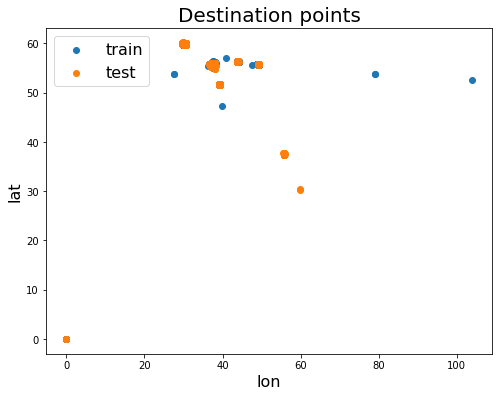

In [7]:
plt.figure(figsize=(8, 6))
plt.title('Destination points', fontsize=20)
plt.scatter(df_train['lon'], df_train['lat'],label = 'train')
plt.scatter(df_test['lon'], df_test['lat'],label = 'test')
plt.xlabel('lon', fontsize=16)
plt.ylabel('lat', fontsize=16)
plt.legend(fontsize=16)
plt.show()

Заметим, что в данных присутствуют аномальнае значения координат, видимо, эти точки в заказе были выбраны случайно.
Точкам (0,0) соответствуют заказы без места назначения.

In [8]:
df_train[(df_train['lon'] > 40) & (df_train['lon'] < 42)]

,dist,due,f_class,lat,lon,s_class,t_class,target
489459,-1.0,2014-02-04 14:03:17.000,econom,57.019952,40.955469,business,NaN,1


In [9]:
df_train[df_train['lon'] > 60]

,dist,due,f_class,lat,lon,s_class,t_class,target
123950,4.149587e+06,2014-01-05 17:50:00.000,econom,52.56223,103.875951,business,NaN,1
895059,2.618817e+06,2014-01-13 21:00:00.000,econom,53.85986,79.027275,NaN,NaN,1
1109054,2.633316e+06,2014-01-24 14:40:00.000,econom,53.85986,79.027275,NaN,NaN,1


Заметим, что, как и предполагалось, поездки для аномальных точек были отменены

Также видим, что в тестовой выборке у некоторых точек перепутаны координаты 

Найдём для каждой точки координаты ближайшего города. Исправим точки, которые перемутаны. Если точка всё же поставлена случано, то удалим её.

In [3]:
def bw(self: pd.Series, a, b):
    return (a <= self) & (self <= b)

pd.Series.bw = bw

def define_city(df):
    df['city'] = 'invalid'
    df.loc[df.lat.bw(59.4, 60.3) & df.lon.bw(29.5, 30.9), 'city'] = 'spb'
    df.loc[df.lat.bw(54.8, 56.5) & df.lon.bw(36.2, 38.3), 'city'] = 'moscow'
    df.loc[df.lat.bw(51.5, 51.9) & df.lon.bw(38.8, 39.6), 'city'] = 'voronezh'
    df.loc[df.lat.bw(56.1, 56.45) & df.lon.bw(43.6, 44.25), 'city'] = 'nnovgorod'
    df.loc[df.lat.bw(55.5, 56) & df.lon.bw(48.8, 49.9), 'city'] = 'kazan'
    df.loc[(df.lat == 0) & (df.lon == 0), 'city'] = 'non-defined'
    
    buf1 = df.loc[df['city'] == 'invalid','lon']
    buf2 = df.loc[df['city'] == 'invalid','lat']
    df.loc[df['city'] == 'invalid','lat'] = buf1.values
    df.loc[df['city'] == 'invalid','lon'] = buf2.values
    
    df.loc[df.lat.bw(59.4, 60.3) & df.lon.bw(29.5, 30.9), 'city'] = 'spb'
    df.loc[df.lat.bw(54.8, 56.5) & df.lon.bw(36.2, 38.3), 'city'] = 'moscow'
    df.loc[df.lat.bw(51.5, 51.9) & df.lon.bw(38.8, 39.6), 'city'] = 'voronezh'
    df.loc[df.lat.bw(56.1, 56.45) & df.lon.bw(43.6, 44.25), 'city'] = 'nnovgorod'
    df.loc[df.lat.bw(55.5, 56) & df.lon.bw(48.8, 49.9), 'city'] = 'kazan'
    
    buf1 = df.loc[df['city'] == 'invalid','lon']
    buf2 = df.loc[df['city'] == 'invalid','lat']
    df.loc[df['city'] == 'invalid','lat'] = buf1.values
    df.loc[df['city'] == 'invalid','lon'] = buf2.values
    del buf1
    del buf2

In [4]:
define_city(df_train)

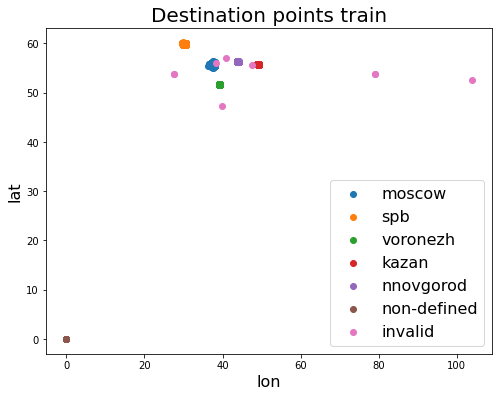

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Destination points train', fontsize=20)
for i in df_train['city'].unique():
    plt.scatter(df_train.loc[df_train['city'] == i , 'lon'] , df_train.loc[df_train['city'] == i , 'lat'] , label = i)
plt.xlabel('lon', fontsize=16)
plt.ylabel('lat', fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [5]:
define_city(df_test)

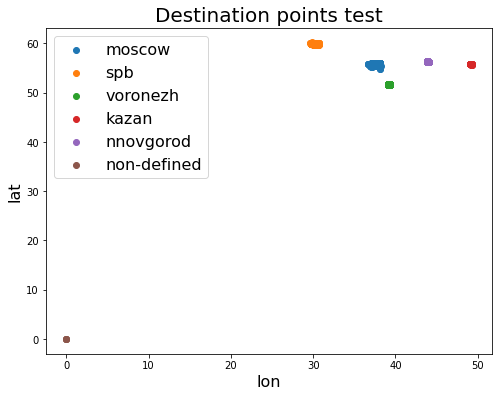

In [8]:
plt.figure(figsize=(8, 6))
plt.title('Destination points test', fontsize=20)
for i in df_test['city'].unique():
    plt.scatter(df_test.loc[df_test['city'] == i , 'lon'] , df_test.loc[df_test['city'] == i , 'lat'] , label = i)
plt.xlabel('lon', fontsize=16)
plt.ylabel('lat', fontsize=16)
plt.legend(fontsize=16)
plt.show()

Таким образом, можем удалить из обучающей выборки ошибочные значения точек, куда делали заказ. В тестовой выборке таким объектам будем присваивать значение 1

In [6]:
df_train.drop(labels = df_train[df_train['city'] == 'invalid'].index, inplace = True)

In [7]:
df_train = df_train.reset_index(drop = True)

In [8]:
df_test[df_test['city'] == 'invalid']

,dist,due,f_class,lat,lon,s_class,t_class,city


Добавим признак: расстояние от точки заказа до центра ближайшего города 

In [9]:
city_centers = {'moscow':[37.61556, 55.75222], 'spb':[30.31413, 59.93863], 'voronezh': [39.1843, 51.67204],
               'nnovgorod': [44.00205 ,56.32867], 'kazan': [49.12214, 55.78874]}

city_names = ['moscow', 'spb', 'voronezh', 'nnovgorod', 'kazan']

city_centers_values = np.array([[37.61556, 55.75222], [30.31413, 59.93863], [39.1843, 51.67204],
                        [44.00205 ,56.32867], [49.12214, 55.78874]])

In [10]:
def euclidean_distance(x, y):
    u = np.diagonal((x @ x.T)).reshape(x.shape[0], 1)   # квадраты векторов из матрицы x
    v = np.diagonal(y @ y.T).reshape(1, y.shape[0])     # квадраты векторов из матрицы y
    # приводим к нужной размерности, так как на выходе должна быть матрица попарных расстояний
    u = u @ np.ones(y.shape[0]).reshape(1, y.shape[0])
    v = np.ones(x.shape[0]).reshape(x.shape[0], 1) @ v
    return np.sqrt(u + v - 2*(x @ y.T))  # вычитаем попарные скалярные произведения векторов из x и векторов из y

In [11]:
def nearest_city(a):
    return np.min(euclidean_distance(a.reshape(1,-1), city_centers_values))
def count_dist_to_nearest_city(df):
    df['dist_to_nearest_city'] = np.apply_along_axis(nearest_city, 1, df[['lon','lat']].values) 
    df.loc[df.lat == 0,'dist_to_nearest_city'] = np.NaN
    df['is_NaN_dist_to_nearest_city'] = 0
    df.loc[df.dist_to_nearest_city.isna(), 'is_NaN_dist_to_nearest_city'] = 1
    df.dist_to_nearest_city.fillna(df.dist_to_nearest_city.mean(), inplace = True)

In [11]:
%%time

count_dist_to_nearest_city(df_train)

CPU times: user 33 s, sys: 8.3 ms, total: 33.1 s
Wall time: 33.1 s


In [12]:
%%time

count_dist_to_nearest_city(df_test)

CPU times: user 14.3 s, sys: 20 ms, total: 14.4 s
Wall time: 14.4 s


In [13]:
def dist_to_city(df):
    for i in tqdm(range(len(city_names))):
        def euclid_dist_to_city(a):
            return euclidean_distance(a.reshape(1,-1), city_centers_values[i].reshape(1,-1))[0][0]
        df['dist_to_'+str(city_names[i])] = np.apply_along_axis(euclid_dist_to_city, 1, df[['lon','lat']].values) 
        df.loc[df.lat == 0,'dist_to_'+str(city_names[i])] = 0    

In [14]:
dist_to_city(df_train)

100%|█████████████████████████████████████████████| 5/5 [02:16<00:00, 27.32s/it]


In [15]:
dist_to_city(df_test)

100%|█████████████████████████████████████████████| 5/5 [01:00<00:00, 12.09s/it]


In [12]:
def nearest_city_m(a):
    def take(b):
        return geodesic(a, np.flip(b)).m
    return np.min(np.apply_along_axis(take, 1, city_centers_values)) 
def count_dist_to_nearest_city_m(df):
    df['dist_to_nearest_city_m'] = np.apply_along_axis(nearest_city_m, 1, df[['lat','lon']].values)
    df.loc[df.lat == 0,'dist_to_nearest_city_m'] = np.NaN
    df['is_NaN_dist_to_nearest_city_m'] = 0
    df.loc[df.dist_to_nearest_city_m.isna(), 'is_NaN_dist_to_nearest_city_m'] = 1
    df.dist_to_nearest_city_m.fillna(df.dist_to_nearest_city_m.mean(), inplace = True)

In [13]:
%%time

count_dist_to_nearest_city_m(df_train)

CPU times: user 23min 42s, sys: 21.1 s, total: 24min 4s
Wall time: 22min 56s


In [14]:
%%time

count_dist_to_nearest_city_m(df_test)

CPU times: user 10min 6s, sys: 9.52 s, total: 10min 16s
Wall time: 9min 44s


In [15]:
pearsonr(df_train['dist_to_nearest_city_m'],df_train['target'])[0]

0.08461743416726576

Определим, в другой ли город делал заказ человек. Сначала определим для каждого города его диаметр. Вычислительно проще это сделать с помощью вычисления расстояний между точками, которые использовали для определения границ городов. Тогда если длина маршрута превышает этот диаметр, то заказ был сделан в другом городе.

In [17]:
city_borders = {'moscow':np.array([[36.2, 54.8],[38.3, 56.5]]), 
                'spb':np.array([[29.5, 59.4],[30.9, 60.3]]),
                'voronezh': np.array([[38.8, 51.5],[39.6, 51.9]]), 
                'nnovgorod': np.array([[43.6, 56.1],[44.25, 56.45]]),
                'kazan': np.array([[48.8, 55.5],[49.9, 56]])}

In [18]:
def to_another_city(df):
    df['another_city'] = 0
    df.loc[df.lat == 0, 'another_city'] = 2  # 2 - для заказов, в которых не указана точка назначения
    df.loc[df.dist == -1,'another_city'] = 3  # 3 - для заказов, в которых не указана длина маршрута
    for i in city_names:
        borders = city_borders[i]
        d = geodesic(np.flip(city_borders[i][0]),np.flip(city_borders[i][1])).m
        df.loc[(df.city == i) & (df.dist > d), 'another_city'] = 1

In [19]:
to_another_city(df_train)

In [20]:
to_another_city(df_test)

In [25]:
pearsonr(df_train.target, df_train.another_city)

(0.12674865533387403, 0.0)

Определим, из какого города сделан заказ, где это возможно. То есть если мы определили, что из другого, то смотрим, к расстоянию между какими городами ближе всего значение dist 

In [21]:
city_centers

{'moscow': [37.61556, 55.75222],
 'spb': [30.31413, 59.93863],
 'voronezh': [39.1843, 51.67204],
 'nnovgorod': [44.00205, 56.32867],
 'kazan': [49.12214, 55.78874]}

In [22]:
def city_distances(a):
    def func(b):
        return geodesic(np.flip(a), np.flip(b)).m
    return np.apply_along_axis(func, 1, city_centers_values)

In [23]:
city_distances = np.apply_along_axis(city_distances, 1, city_centers_values)

In [24]:
city_distances

array([[      0.        ,  636016.66692912,  465752.36349851,
         403043.28993595,  721357.34348654],
       [ 636016.66692912,       0.        , 1073322.07651671,
         898783.47502908, 1203019.49506277],
       [ 465752.36349851, 1073322.07651671,       0.        ,
         606665.22701872,  798875.85215048],
       [ 403043.28993595,  898783.47502908,  606665.22701872,
              0.        ,  324507.33194986],
       [ 721357.34348654, 1203019.49506277,  798875.85215048,
         324507.33194986,       0.        ]])

In [25]:
df_train['from_city'] = df_train['city']

for i in range(len(city_names)):
    df_city = df_train[(df_train.another_city == 1) & (df_train.city == city_names[i])]
    def find_close(a):
        return city_names[np.argmin(np.abs(a - city_distances[i]))]
    df_train.loc[(df_train.another_city == 1) & (df_train.city == city_names[i]), 'from_city'] = np.apply_along_axis(find_close, 1, df_city.dist.values.reshape(-1,1))
    
df_train.loc[df_train.dist == -1, 'from_city'] = 'non-defined'

In [26]:
df_train['from_city'].unique()

array(['moscow', 'non-defined', 'spb', 'voronezh', 'kazan', 'nnovgorod',
       'mos', 'kaz', 'nno', 'vor'], dtype=object)

In [27]:
map_ = {'moscow': 'moscow', 'non-defined':'non-defined', 'spb':'spb', 'voronezh':'voronezh', 'kazan':'kazan',
        'nnovgorod': 'nnovgorod', 'mos': 'moscow', 'kaz': 'kazan', 'nno': 'nnovgorod', 'vor': 'voronezh'}
df_train['from_city'] = df_train['from_city'].map(map_)

In [28]:
df_train['from_city'].unique()

array(['moscow', 'non-defined', 'spb', 'voronezh', 'kazan', 'nnovgorod'],
      dtype=object)

In [29]:
df_test['from_city'] = df_test['city']

for i in range(len(city_names)):
    df_city = df_test[(df_test.another_city == 1) & (df_test.city == city_names[i])]
    def find_close(a):
        return city_names[np.argmin(np.abs(a - city_distances[i]))]
    df_test.loc[(df_test.another_city == 1) & (df_test.city == city_names[i]), 'from_city'] = np.apply_along_axis(find_close, 1, df_city.dist.values.reshape(-1,1))
    
df_test.loc[df_test.dist == -1, 'from_city'] = 'non-defined'

In [30]:
df_test['from_city'].unique()

array(['moscow', 'non-defined', 'spb', 'voronezh', 'kazan', 'nnovgorod',
       'nnovgoro', 'nno', 'mos', 'nnovgo', 'vorone'], dtype=object)

In [31]:
map_ = {'moscow': 'moscow', 'non-defined':'non-defined', 'spb':'spb', 'voronezh':'voronezh', 'kazan':'kazan',
        'nnovgorod': 'nnovgorod', 'nnovgoro': 'nnovgorod', 'nno': 'nnovgorod', 'mos': 'moscow', 'nnovgo': 'nnovgorod','vorone': 'voronezh'}
df_test['from_city'] = df_test['from_city'].map(map_)

In [32]:
df_test['from_city'].unique()

array(['moscow', 'non-defined', 'spb', 'voronezh', 'kazan', 'nnovgorod'],
      dtype=object)

Количество заказов из этого города

In [33]:
def number_orders_from(df):
    a = dict(df.groupby('from_city')['dist'].count())
    df['number_of_orders_from_city'] = df['from_city'].map(a)

In [34]:
number_orders_from(df_train)
number_orders_from(df_test)

Количество заказов в этот город

In [35]:
def number_orders_to(df):
    a = dict(df.groupby('city')['dist'].count())
    df['number_of_orders_to_city'] = df['city'].map(a)

In [36]:
number_orders_to(df_train)
number_orders_to(df_test)

Заменим расстояния на ранги

In [37]:
def ranked_dist_all(df):
    df['ranked_dist_all'] = rankdata(df['dist'], method = 'min')

In [38]:
ranked_dist_all(df_train)
ranked_dist_all(df_test)

In [39]:
def ranked_dist_from_city(df):
    for i in df['from_city'].unique():
        mask = df[df_train['from_city'] == i].index
        df.loc[mask, 'ranked_dist_from_city'] = rankdata(df.loc[mask]['dist'], method = 'min')
    df['ranked_dist_from_city'] = df['ranked_dist_from_city'].astype('int64')

In [40]:
def ranked_dist_to_city(df):
    for i in df['city'].unique():
        mask = df[df_train['city'] == i].index
        df.loc[mask, 'ranked_dist_to_city'] = rankdata(df.loc[mask]['dist'], method = 'min')
    df['ranked_dist_to_city'] = df['ranked_dist_to_city'].astype('int64')

In [41]:
ranked_dist_from_city(df_train)
ranked_dist_from_city(df_test)

In [42]:
ranked_dist_to_city(df_train)
ranked_dist_to_city(df_test)

# Класс авто

In [43]:
def fill_nan_class(df):
    for i in ['f_class', 's_class', 't_class']:
        df[i] = df[i].fillna('non-defined')

In [44]:
fill_nan_class(df_train)
fill_nan_class(df_test)

Количество заказов из этого города такого же класса(f, s t)

In [45]:
def number_of_orders_from_city_same_class(df):
    for j in ['f_class', 's_class', 't_class']:
        for i in df[j].unique():
            mask = df[df[j] == i].index
            a = dict(df.loc[mask].groupby('from_city')['dist'].count())
            df.loc[mask, 'number_of_orders_from_city_same_'+j] = df.loc[mask, 'from_city'].map(a)
        df['number_of_orders_from_city_same_'+j] = df['number_of_orders_from_city_same_'+j].astype('int64')

Количество заказов в этот город такого же класса(f, s t)

In [46]:
def number_of_orders_to_city_same_class(df):
    for j in ['f_class', 's_class', 't_class']:
        for i in df[j].unique():
            mask = df[df[j] == i].index
            a = dict(df.loc[mask].groupby('city')['dist'].count())
            df.loc[mask, 'number_of_orders_to_city_same_'+j] = df.loc[mask, 'city'].map(a)
        df['number_of_orders_to_city_same_'+j] = df['number_of_orders_to_city_same_'+j].astype('int64')

In [47]:
number_of_orders_from_city_same_class(df_train)
number_of_orders_to_city_same_class(df_train)
number_of_orders_from_city_same_class(df_test)
number_of_orders_to_city_same_class(df_test)

Сформируем рейтинг заказчика по его топ-классам 

In [48]:
def classes_to_int(df):
    '''
    f_class:
    
    econom -> 3*1 
    business -> 3*2 
    vip -> 3*3 
    non-defined -> 0
    
    s_class:
    
    econom -> 2*1 
    business -> 2*2 
    vip -> 2*3 
    non-defined -> 0
    
    t_class:
    
    econom -> 1 
    business -> 2 
    vip -> 3 
    non-defined -> 0
    
    '''
    for j in range(len(['f_class', 's_class', 't_class'])):
        class_to_int = {'non-defined':0*(3-j) , 'econom':1*(3-j), 'business':2*(3-j), 'vip':3*(3-j)} 
        df[['f_class', 's_class', 't_class'][j]+'_int'] = df[['f_class', 's_class', 't_class'][j]].map(class_to_int)
        
    df['auto_class_rating'] = df['f_class'+'_int'] + df['s_class'+'_int'] + df['t_class'+'_int']
    del df['f_class'+'_int']
    del df['s_class'+'_int']
    del df['t_class'+'_int']

In [49]:
classes_to_int(df_train)
classes_to_int(df_test)

Количество заказов из этого города с таким же рейтингом

In [50]:
def number_of_orders_from_city_same_class_rating(df):
    for i in df['auto_class_rating'].unique():
        mask = df[df['auto_class_rating'] == i].index
        a = dict(df.loc[mask].groupby('from_city')['dist'].count())
        df.loc[mask, 'number_of_orders_from_city_same_class_rating'] = df.loc[mask, 'from_city'].map(a)
    df['number_of_orders_from_city_same_class_rating'] = df['number_of_orders_from_city_same_class_rating'].astype('int64')

In [51]:
number_of_orders_from_city_same_class_rating(df_train)
number_of_orders_from_city_same_class_rating(df_test)

Количество заказов в этот город с таким же рейтингом

In [52]:
def number_of_orders_to_city_same_class_rating(df):
    for i in df['auto_class_rating'].unique():
        mask = df[df['auto_class_rating'] == i].index
        a = dict(df.loc[mask].groupby('city')['dist'].count())
        df.loc[mask, 'number_of_orders_to_city_same_class_rating'] = df.loc[mask, 'city'].map(a)
    df['number_of_orders_to_city_same_class_rating'] = df['number_of_orders_to_city_same_class_rating'].astype('int64')

In [53]:
number_of_orders_to_city_same_class_rating(df_train)
number_of_orders_to_city_same_class_rating(df_test)

Количество заказов из этого города с рейтингом выше

In [54]:
def number_of_orders_from_city_better_class_rating(df):
    for k in df['from_city'].unique():
    
        mask = df['from_city'] == k
    
        a = dict(df.loc[mask].groupby('auto_class_rating')['dist'].count())

        b = []
        for i in range(len(np.sort(df.loc[mask,'auto_class_rating'].unique()))):
            sum_ = 0
            for j in range(i+1, len(np.sort(df.loc[mask,'auto_class_rating'].unique()))):
                sum_ += a[np.sort(df.loc[mask,'auto_class_rating'].unique())[j]] 
            b.append(sum_)

        c = {}
        for i in range(len(df.loc[mask,'auto_class_rating'].unique())):
            c[np.sort(df.loc[mask,'auto_class_rating'].unique())[i]] = b[i]
        df.loc[mask, 'number_of_orders_from_city_better_class_rating'] = df.loc[mask, 'auto_class_rating'].map(c)
    df['number_of_orders_from_city_better_class_rating'] = df['number_of_orders_from_city_better_class_rating'].astype('int64')

Количество заказов в этот город с рейтингом выше

In [55]:
def number_of_orders_to_city_better_class_rating(df):
    for k in df['city'].unique():
    
        mask = df['city'] == k
    
        a = dict(df.loc[mask].groupby('auto_class_rating')['dist'].count())

        b = []
        for i in range(len(np.sort(df.loc[mask,'auto_class_rating'].unique()))):
            sum_ = 0
            for j in range(i+1, len(np.sort(df.loc[mask,'auto_class_rating'].unique()))):
                sum_ += a[np.sort(df.loc[mask,'auto_class_rating'].unique())[j]] 
            b.append(sum_)

        c = {}
        for i in range(len(df.loc[mask,'auto_class_rating'].unique())):
            c[np.sort(df.loc[mask,'auto_class_rating'].unique())[i]] = b[i]
        df.loc[mask, 'number_of_orders_to_city_better_class_rating'] = df.loc[mask, 'auto_class_rating'].map(c) 
    df['number_of_orders_to_city_better_class_rating'] = df['number_of_orders_to_city_better_class_rating'].astype('int64')

In [56]:
number_of_orders_from_city_better_class_rating(df_train)
number_of_orders_from_city_better_class_rating(df_test)
number_of_orders_to_city_better_class_rating(df_train)
number_of_orders_to_city_better_class_rating(df_test)

Какой процент составляет количество заказов с таким же рейтигом от общего числа заказов из этого города

In [57]:
def num_orders_from_city_same_class_rating_ratio(df):
    df['num_orders_from_city_same_class_rating_ratio'] = df['number_of_orders_from_city_same_class_rating'] / df['number_of_orders_from_city']

In [58]:
num_orders_from_city_same_class_rating_ratio(df_train)
num_orders_from_city_same_class_rating_ratio(df_test)

Какой процент составляет количество заказов с таким же рейтигом от общего числа заказов в этот город

In [59]:
def num_orders_to_city_same_class_rating_ratio(df):
    df['num_orders_to_city_same_class_rating_ratio'] = df['number_of_orders_to_city_same_class_rating'] / df['number_of_orders_to_city']

In [60]:
num_orders_to_city_same_class_rating_ratio(df_train)
num_orders_to_city_same_class_rating_ratio(df_test)

Какой процент составляет количество заказов с рейтигом выше от общего числа заказов из этого города

In [61]:
def num_orders_from_city_better_class_rating_ratio(df):
    df['num_orders_from_city_better_class_rating_ratio'] = df['number_of_orders_from_city_better_class_rating'] / df['number_of_orders_from_city']

In [62]:
num_orders_from_city_better_class_rating_ratio(df_train)
num_orders_from_city_better_class_rating_ratio(df_test)

Какой процент составляет количество заказов с рейтигом выше от общего числа заказов в этот город

In [63]:
def num_orders_to_city_better_class_rating_ratio(df):
    df['num_orders_to_city_better_class_rating_ratio'] = df['number_of_orders_to_city_better_class_rating'] / df['number_of_orders_from_city']

In [64]:
num_orders_to_city_better_class_rating_ratio(df_train)
num_orders_to_city_better_class_rating_ratio(df_test)

Количество заказов в другой город, в тот же город и неизвестных заказов из этого города

In [65]:
def number_of_orders_from_city_to_another_city(df):
    for i in df['another_city'].unique():
        mask = df['another_city'] == i
        a = dict(df.loc[mask].groupby('from_city')['dist'].count())
        df.loc[mask, 'number_of_orders_from_city_to_another_city'] = df.loc[mask, 'from_city'].map(a)
    df['number_of_orders_from_city_to_another_city'] = df['number_of_orders_from_city_to_another_city'].astype('int64')

In [66]:
number_of_orders_from_city_to_another_city(df_train)
number_of_orders_from_city_to_another_city(df_test)

Количество заказов в другой город, в тот же город и неизвестных заказов в этот город

In [67]:
def number_of_orders_to_city_to_another_city(df):
    for i in df['another_city'].unique():
        mask = df['another_city'] == i
        a = dict(df.loc[mask].groupby('city')['dist'].count())
        df.loc[mask, 'number_of_orders_to_city_to_another_city'] = df.loc[mask, 'city'].map(a)
    df['number_of_orders_to_city_to_another_city'] = df['number_of_orders_to_city_to_another_city'].astype('int64')

In [68]:
number_of_orders_to_city_to_another_city(df_train)
number_of_orders_to_city_to_another_city(df_test)

Количество заказов из этого города, у которых ranked_dist_from_city такой же

In [69]:
def number_of_orders_from_city_same_ranked_dist_from_city(df):
    for i in df['from_city'].unique():
        mask = df[df['from_city'] == i].index
        a = dict(df.loc[mask].groupby('ranked_dist_from_city')['dist'].count())
        df.loc[mask, 'number_of_orders_from_city_same_ranked_dist_from_city'] = df.loc[mask, 'ranked_dist_from_city'].map(a)
    df['number_of_orders_from_city_same_ranked_dist_from_city'] = df['number_of_orders_from_city_same_ranked_dist_from_city'].astype('int64')

In [70]:
number_of_orders_from_city_same_ranked_dist_from_city(df_train)
number_of_orders_from_city_same_ranked_dist_from_city(df_test)

Количество заказов в этот город, у которых ranked_dist_to_city такой же

In [71]:
def number_of_orders_to_city_same_ranked_dist_to_city(df):
    for i in df['city'].unique():
        mask = df[df['city'] == i].index
        a = dict(df.loc[mask].groupby('ranked_dist_to_city')['dist'].count())
        df.loc[mask, 'number_of_orders_to_city_same_ranked_dist_to_city'] = df.loc[mask, 'ranked_dist_to_city'].map(a)
    df['number_of_orders_to_city_same_ranked_dist_to_city'] = df['number_of_orders_to_city_same_ranked_dist_to_city'].astype('int64')

In [72]:
number_of_orders_to_city_same_ranked_dist_to_city(df_train)
number_of_orders_to_city_same_ranked_dist_to_city(df_test)

Количество заказов, у которых ranked_dist_all такой же 

In [73]:
def number_of_orders_same_ranked_dist_all(df):   
    a = dict(df.groupby('ranked_dist_all')['dist'].count())
    df[ 'number_of_orders_same_ranked_dist_all'] = df['ranked_dist_all'].map(a)
    df['number_of_orders_same_ranked_dist_all'] = df['number_of_orders_same_ranked_dist_all'].astype('int64')

In [74]:
number_of_orders_same_ranked_dist_all(df_train)
number_of_orders_same_ranked_dist_all(df_test)

# Время заказа

Количество заказов из этого города в текущий момент

In [75]:
def number_of_orders_from_city_now(df):
    for i in df['from_city'].unique():
        mask = df[df['from_city'] == i].index
        a = dict(df.loc[mask].groupby('due')['dist'].count())
        df.loc[mask, 'number_of_orders_from_city_now'] = df.loc[mask, 'due'].map(a)
    df['number_of_orders_from_city_now'] = df['number_of_orders_from_city_now'].astype('int64')

In [76]:
number_of_orders_from_city_now(df_train)

In [77]:
number_of_orders_from_city_now(df_test)

Количество заказов в этот город в текущий момент

In [78]:
def number_of_orders_to_city_now(df):
    for i in df['city'].unique():
        mask = df[df['city'] == i].index
        a = dict(df.loc[mask].groupby('due')['dist'].count())
        df.loc[mask, 'number_of_orders_to_city_now'] = df.loc[mask, 'due'].map(a)
    df['number_of_orders_to_city_now'] = df['number_of_orders_to_city_now'].astype('int64')

In [79]:
number_of_orders_to_city_now(df_train)
number_of_orders_to_city_now(df_test)

Количество заказов из этого города такого же класса(f, s t) в текущий момент

In [80]:
def number_of_orders_from_city_same_class_now(df):
    for j in ['f_class', 's_class', 't_class']:
        for k in df['from_city'].unique():
            for i in df[j].unique():
                mask = (df[j] == i) & (df['from_city'] == k)
                a = dict(df.loc[mask].groupby('due')['dist'].count())
                df.loc[mask, 'number_of_orders_from_city_same_'+j+'_now'] = df.loc[mask, 'due'].map(a)
        df['number_of_orders_from_city_same_'+j+'_now'] = df['number_of_orders_from_city_same_'+j+'_now'].astype('int64')

In [81]:
number_of_orders_from_city_same_class_now(df_train)
number_of_orders_from_city_same_class_now(df_test)

Количество заказов в этот город такого же класса(f, s t) в текущий момент

In [82]:
def number_of_orders_to_city_same_class_now(df):
    for j in ['f_class', 's_class', 't_class']:
        for k in df['city'].unique():
            for i in df[j].unique():
                mask = (df[j] == i) & (df['city'] == k)
                a = dict(df.loc[mask].groupby('due')['dist'].count())
                df.loc[mask, 'number_of_orders_to_city_same_'+j+'_now'] = df.loc[mask, 'due'].map(a)
        df['number_of_orders_to_city_same_'+j+'_now'] = df['number_of_orders_to_city_same_'+j+'_now'].astype('int64')

In [83]:
number_of_orders_to_city_same_class_now(df_train)
number_of_orders_to_city_same_class_now(df_test)

Количество заказов такого же рейтинга из этого города в текущий момент

In [84]:
def number_of_orders_from_city_same_class_rating_now(df):
    for k in df['from_city'].unique():
        for i in df['auto_class_rating'].unique():
            mask = (df['auto_class_rating'] == i) & (df['from_city'] == k)
            a = dict(df.loc[mask].groupby('due')['dist'].count())
            df.loc[mask, 'number_of_orders_from_city_same_class_rating_now'] = df.loc[mask, 'due'].map(a)
    df['number_of_orders_from_city_same_class_rating_now'] = df['number_of_orders_from_city_same_class_rating_now'].astype('int64')

In [85]:
number_of_orders_from_city_same_class_rating_now(df_train)

In [86]:
number_of_orders_from_city_same_class_rating_now(df_test)

Количество заказов такого же рейтинга в этот город в текущий момент

In [87]:
def number_of_orders_to_city_same_class_rating_now(df):
    for k in df['city'].unique():
        for i in df['auto_class_rating'].unique():
            mask = (df['auto_class_rating'] == i) & (df['city'] == k)
            a = dict(df.loc[mask].groupby('due')['dist'].count())
            df.loc[mask, 'number_of_orders_to_city_same_class_rating_now'] = df.loc[mask, 'due'].map(a)
    df['number_of_orders_to_city_same_class_rating_now'] = df['number_of_orders_to_city_same_class_rating_now'].astype('int64')

In [88]:
number_of_orders_to_city_same_class_rating_now(df_train)
number_of_orders_to_city_same_class_rating_now(df_test)

Какой процент составляет количество заказов с таким же рейтигом от общего числа заказов из этого города в текущий момент

In [89]:
def num_orders_from_city_same_class_rating_ratio_now(df):
    df['num_orders_from_city_same_class_rating_ratio_now'] = df['number_of_orders_from_city_same_class_rating_now'] / df['number_of_orders_from_city_now']

num_orders_from_city_same_class_rating_ratio_now(df_train)
num_orders_from_city_same_class_rating_ratio_now(df_test)

Какой процент составляет количество заказов с таким же рейтигом от общего числа заказов в этот город в текущий момент

In [90]:
def num_orders_to_city_same_class_rating_ratio_now(df):
    df['num_orders_to_city_same_class_rating_ratio_now'] = df['number_of_orders_to_city_same_class_rating_now'] / df['number_of_orders_to_city_now']

num_orders_to_city_same_class_rating_ratio_now(df_train)
num_orders_to_city_same_class_rating_ratio_now(df_test)

Количество заказов в другой город, в тот же город и неизвестных заказов из этого города в текущий момент

In [91]:
def number_of_orders_from_city_to_another_city_now(df):
    for i in df['another_city'].unique():
        for j in df['from_city'].unique():
            mask = (df['another_city'] == i) & (df['from_city'] == j)
            a = dict(df.loc[mask].groupby('due')['dist'].count())
            df.loc[mask, 'number_of_orders_from_city_to_another_city_now'] = df.loc[mask, 'due'].map(a)
    df['number_of_orders_from_city_to_another_city_now'] = df['number_of_orders_from_city_to_another_city_now'].astype('int64')

In [92]:
number_of_orders_from_city_to_another_city_now(df_train)
number_of_orders_from_city_to_another_city_now(df_test)

Количество заказов в другой город, в тот же город и неизвестных заказов в этот город в текущий момент

In [93]:
def number_of_orders_to_city_to_another_city_now(df):
    for i in df['another_city'].unique():
        for j in df['city'].unique():
            mask = (df['another_city'] == i) & (df['city'] == j)
            a = dict(df.loc[mask].groupby('due')['dist'].count())
            df.loc[mask, 'number_of_orders_to_city_to_another_city_now'] = df.loc[mask, 'due'].map(a)
    df['number_of_orders_to_city_to_another_city_now'] = df['number_of_orders_to_city_to_another_city_now'].astype('int64')

In [94]:
number_of_orders_to_city_to_another_city_now(df_train)
number_of_orders_to_city_to_another_city_now(df_test)

Было ли сделано в эту точку больше одного заказа

In [95]:
def several_orders_to_this_point(df):
    a = dict(df.groupby(['lat', 'lon'])['due'].count())
    df['several_orders_to_this_point'] = df[['lat', 'lon']].set_index(['lat','lon']).index.map(a)
    df.loc[df['several_orders_to_this_point'] > 1, 'several_orders_to_this_point'] = 0 

In [96]:
several_orders_to_this_point(df_train)
several_orders_to_this_point(df_test)

# Находим заказы одних людей

Если в одну точку сделано несколько заказов, то ставим 1 посленим заказам, а всем остальным(если их больше 1) 0

In [97]:
def last_order1(df):
    inx = df.groupby(['lat', 'lon'])['due'].transform(max) == df['due']
    df.loc[inx, 'last_order1'] = 1
    df['last_order1'] = df['last_order1'].fillna(0)
    df['last_order1'] = df['last_order1'].astype('int64')

In [98]:
last_order1(df_train)

In [99]:
last_order1(df_test)

У них должны совпадать 'f_class', 's_class', 't_class', 'city', 'from_city', 'dist'

In [100]:
def last_order2(df):
    inx = df.groupby(['f_class', 's_class', 't_class' , 'city', 'from_city', 'dist'])['due'].transform(max) == df['due']
    df.loc[inx, 'last_order2'] = 1
    df['last_order2'] = df['last_order2'].fillna(0)
    df['last_order2'] = df['last_order2'].astype('int64')

In [101]:
last_order2(df_train)

In [102]:
last_order2(df_test)

Поделим dist на бины

In [103]:
def cuted_dist_from_city(df):
    for i in df['from_city'].unique():
        mask = df['from_city'] == i
        df.loc[mask, 'cuted_dist_from_city'] = pd.cut(df.loc[mask, 'dist'], int(mask.sum() * 0.1), labels=False)
    df['cuted_dist_from_city'] = df['cuted_dist_from_city'].astype('int64')

In [104]:
cuted_dist_from_city(df_train)
cuted_dist_from_city(df_test)

In [105]:
def cuted_dist_to_city(df):
    for i in df['city'].unique():
        mask = df['city'] == i
        if (i == 'non-defined'):
            df.loc[mask, 'cuted_dist_to_city'] = 0
        else:
            df.loc[mask, 'cuted_dist_to_city'] = pd.cut(df.loc[mask, 'dist'], int(mask.sum() * 0.1), labels=False)
    df['cuted_dist_to_city'] = df['cuted_dist_to_city'].astype('int64')

In [106]:
cuted_dist_to_city(df_train)
cuted_dist_to_city(df_test)

У них должны совпадать 'f_class', 's_class', 't_class', 'city', 'from_city', 'lat', 'lon'

In [107]:
def last_order3(df):
    inx = df.groupby(['f_class', 's_class', 't_class' , 'city', 'from_city', 'lat', 'lon'])['due'].transform(max) == df['due']
    df.loc[inx, 'last_order3'] = 1
    df['last_order3'] = df['last_order3'].fillna(0)
    df['last_order3'] = df['last_order3'].astype('int64')

In [108]:
last_order3(df_train)
last_order3(df_test)

In [109]:
def order_time(df):
    df.due = df.due.astype('datetime64[ns]')
    df.set_index('due',inplace = True)
    df["minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["weekday"] = df.index.weekday
    df['is_weekend'] = df.weekday.isin([5,6])*1

In [110]:
order_time(df_train)
order_time(df_test)

Час пик или нет

In [111]:
def peak_hour(df):
    df['peak_hour'] = 0
    df.loc[(df.is_weekend == 0)&(((df.index.hour >= 7) & (df.index.hour <= 11)) | ((df.index.hour >= 17) & (df.index.hour <= 20)) ), 'peak_hour'] = 1

In [112]:
peak_hour(df_train)
peak_hour(df_test)

Время суток

In [113]:
def time_of_day(df):
    df.loc[(df.index.hour >= 7) & (df.index.hour <= 11), 'time_of_day'] = 'morning'
    df.loc[(df.index.hour > 11) & (df.index.hour < 17), 'time_of_day'] = 'afternoon'
    df.loc[(df.index.hour >= 17) & (df.index.hour <= 20), 'time_of_day'] = 'evening'
    df.loc[((df.index.hour > 20) & (df.index.hour <= 23)) | ((df.index.hour >= 0) & (df.index.hour <= 2)), 'time_of_day'] = 'late_evening'
    df.loc[(df.index.hour > 2) & (df.index.hour < 7), 'time_of_day'] = 'night'

In [114]:
time_of_day(df_train)
time_of_day(df_test)

In [115]:
df_test = df_test.reset_index()
df_train = df_train.reset_index()

Сделаем категориальный признак point = lat * lon

In [59]:
df_train['point'] = df_train['lat'] * df_train['lon']
del df_train['lat']
del df_train['lon']
df_test['point'] = df_test['lat'] * df_test['lon']
del df_test['lat']
del df_test['lon']

In [116]:
df_train.isna().sum().sum()

0

In [117]:
df_test.isna().sum().sum()

0

Сохранение и загрузка признаков. Пропустить, если признаки посчитаны в ноутбуке

In [70]:
#df_train.to_csv('train.csv')
#df_test.to_csv('test.csv')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

del df_train['Unnamed: 0']
del df_test['Unnamed: 0']

Преобразование типов

In [402]:
#for i in ['last_order1', 'last_order2', 'cuted_dist_from_city', 'cuted_dist_to_city', 'last_order3']:
#        df_train[i] = df_train[i].astype('int64')

In [404]:
#for i in ['last_order1', 'last_order2', 'cuted_dist_from_city', 'cuted_dist_to_city', 'last_order3']:
#        df_test[i] = df_test[i].astype('int64')

In [471]:
#for i in ['is_NaN_dist_to_nearest_city', 'is_NaN_dist_to_nearest_city_m', 'target']:
#    df_train[i] = df_train[i].astype('int64')

In [3]:
for i in df_train.select_dtypes(include=['object']).columns:
    df_train[i] = df_train[i].astype('category')
    
df_train['point'] = df_train['point'].astype('string').astype('category')
    
for i in df_test.select_dtypes(include=['object']).columns:
    df_test[i] = df_test[i].astype('category')
    
df_test['point'] = df_test['point'].astype('string').astype('category')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187452 entries, 0 to 1187451
Data columns (total 70 columns):
 #   Column                                                 Non-Null Count    Dtype   
---  ------                                                 --------------    -----   
 0   dist                                                   1187452 non-null  float64 
 1   f_class                                                1187452 non-null  category
 2   s_class                                                1187452 non-null  category
 3   t_class                                                1187452 non-null  category
 4   target                                                 1187452 non-null  int64   
 5   city                                                   1187452 non-null  category
 6   dist_to_nearest_city                                   1187452 non-null  float64 
 7   is_NaN_dist_to_nearest_city                            1187452 non-null  int64   
 8   dist_to_mosc

# Отбор признаков

Убираем признаки, у которых маленькая корреляция с таргетом

In [5]:
y = df_train['target']

In [6]:
df_train.drop(columns = 'target', inplace = True)

In [7]:
remaining_features = []
del_features = []
print("START DIMENSION", df_train.shape[1])
for i in df_train.columns:
    try:
        if np.abs(pearsonr(df_train[i], y)[0]) > 0.0:
            remaining_features.append(i)
        else:
            del_features.append(i)
    except:
        remaining_features.append(i)
        continue
    
TRAIN = df_train[remaining_features]
print("END DIMENSION", TRAIN.shape[1])
print('deleted features', del_features)

START DIMENSION 69
END DIMENSION 69
deleted features []


# Tuning

In [8]:
from scipy.stats import randint

In [9]:
cat_features = []
for i in range(len(TRAIN.columns)):
    if TRAIN.columns[i] in TRAIN.select_dtypes(include=['category']).columns:
        cat_features.append(i)

In [13]:
cbc = catboost.CatBoostClassifier(iterations = 30, cat_features = cat_features)

param_dist = {"learning_rate": np.linspace(0,0.2,5),
               "max_depth": randint(3, 10)}
    

In [14]:
rscv = RandomizedSearchCV(cbc , param_dist, scoring='roc_auc', cv=5)

rscv.fit(TRAIN,y)

print(rscv.best_params_)
print(rscv.best_score_)

0:	learn: 0.6596433	total: 460ms	remaining: 13.3s
1:	learn: 0.6306177	total: 799ms	remaining: 11.2s
2:	learn: 0.6039915	total: 1.14s	remaining: 10.2s
3:	learn: 0.5802644	total: 1.4s	remaining: 9.12s
4:	learn: 0.5591315	total: 1.7s	remaining: 8.49s
5:	learn: 0.5411657	total: 2.06s	remaining: 8.24s
6:	learn: 0.5253825	total: 2.25s	remaining: 7.41s
7:	learn: 0.5104973	total: 2.55s	remaining: 7.02s
8:	learn: 0.4973468	total: 2.87s	remaining: 6.71s
9:	learn: 0.4862175	total: 3.18s	remaining: 6.37s
10:	learn: 0.4761530	total: 3.48s	remaining: 6.02s
11:	learn: 0.4667532	total: 3.78s	remaining: 5.67s
12:	learn: 0.4583408	total: 4.11s	remaining: 5.37s
13:	learn: 0.4515473	total: 4.38s	remaining: 5.01s
14:	learn: 0.4453240	total: 4.69s	remaining: 4.69s
15:	learn: 0.4392209	total: 5s	remaining: 4.38s
16:	learn: 0.4341005	total: 5.29s	remaining: 4.05s
17:	learn: 0.4294077	total: 5.59s	remaining: 3.73s
18:	learn: 0.4250411	total: 5.92s	remaining: 3.43s
19:	learn: 0.4212550	total: 6.25s	remaining: 3

13:	learn: 0.4515473	total: 4.92s	remaining: 5.62s
14:	learn: 0.4453240	total: 5.2s	remaining: 5.2s
15:	learn: 0.4392209	total: 5.53s	remaining: 4.84s
16:	learn: 0.4341005	total: 5.8s	remaining: 4.44s
17:	learn: 0.4294077	total: 6.11s	remaining: 4.07s
18:	learn: 0.4250411	total: 6.44s	remaining: 3.73s
19:	learn: 0.4212550	total: 6.76s	remaining: 3.38s
20:	learn: 0.4179564	total: 7.05s	remaining: 3.02s
21:	learn: 0.4151390	total: 7.35s	remaining: 2.67s
22:	learn: 0.4125573	total: 7.67s	remaining: 2.33s
23:	learn: 0.4099821	total: 8.02s	remaining: 2.01s
24:	learn: 0.4077189	total: 8.33s	remaining: 1.67s
25:	learn: 0.4056798	total: 8.63s	remaining: 1.33s
26:	learn: 0.4037747	total: 8.94s	remaining: 993ms
27:	learn: 0.4021351	total: 9.22s	remaining: 658ms
28:	learn: 0.4006834	total: 9.52s	remaining: 328ms
29:	learn: 0.3994827	total: 9.86s	remaining: 0us
0:	learn: 0.6596844	total: 329ms	remaining: 9.55s
1:	learn: 0.6306966	total: 670ms	remaining: 9.38s
2:	learn: 0.6041050	total: 1.03s	remai

26:	learn: 0.3809061	total: 7.76s	remaining: 862ms
27:	learn: 0.3806590	total: 7.99s	remaining: 571ms
28:	learn: 0.3804924	total: 8.42s	remaining: 290ms
29:	learn: 0.3802128	total: 8.7s	remaining: 0us
0:	learn: 0.5999877	total: 274ms	remaining: 7.94s
1:	learn: 0.5374141	total: 516ms	remaining: 7.23s
2:	learn: 0.4919871	total: 751ms	remaining: 6.76s
3:	learn: 0.4629307	total: 1.02s	remaining: 6.62s
4:	learn: 0.4415047	total: 1.25s	remaining: 6.26s
5:	learn: 0.4272732	total: 1.48s	remaining: 5.91s
6:	learn: 0.4174093	total: 1.71s	remaining: 5.62s
7:	learn: 0.4104587	total: 2.01s	remaining: 5.52s
8:	learn: 0.4045677	total: 2.26s	remaining: 5.27s
9:	learn: 0.4005220	total: 2.51s	remaining: 5.03s
10:	learn: 0.3975757	total: 2.77s	remaining: 4.78s
11:	learn: 0.3954802	total: 2.98s	remaining: 4.47s
12:	learn: 0.3939686	total: 3.25s	remaining: 4.24s
13:	learn: 0.3924275	total: 3.47s	remaining: 3.97s
14:	learn: 0.3895571	total: 3.74s	remaining: 3.74s
15:	learn: 0.3876341	total: 3.96s	remaining:

9:	learn: 0.3967016	total: 3.92s	remaining: 7.84s
10:	learn: 0.3934231	total: 4.32s	remaining: 7.46s
11:	learn: 0.3911827	total: 4.7s	remaining: 7.05s
12:	learn: 0.3895949	total: 5.11s	remaining: 6.68s
13:	learn: 0.3866867	total: 5.55s	remaining: 6.34s
14:	learn: 0.3846943	total: 5.93s	remaining: 5.93s
15:	learn: 0.3831684	total: 6.33s	remaining: 5.54s
16:	learn: 0.3818008	total: 6.71s	remaining: 5.13s
17:	learn: 0.3808331	total: 7.13s	remaining: 4.76s
18:	learn: 0.3800139	total: 7.54s	remaining: 4.36s
19:	learn: 0.3793670	total: 7.92s	remaining: 3.96s
20:	learn: 0.3787990	total: 8.29s	remaining: 3.55s
21:	learn: 0.3784257	total: 8.68s	remaining: 3.15s
22:	learn: 0.3779182	total: 9.07s	remaining: 2.76s
23:	learn: 0.3774253	total: 9.47s	remaining: 2.37s
24:	learn: 0.3770205	total: 9.83s	remaining: 1.97s
25:	learn: 0.3767455	total: 10.2s	remaining: 1.57s
26:	learn: 0.3763891	total: 10.6s	remaining: 1.18s
27:	learn: 0.3761889	total: 11s	remaining: 786ms
28:	learn: 0.3759566	total: 11.4s	r

22:	learn: 0.3817296	total: 5.25s	remaining: 1.6s
23:	learn: 0.3815427	total: 5.49s	remaining: 1.37s
24:	learn: 0.3813787	total: 5.72s	remaining: 1.14s
25:	learn: 0.3812466	total: 5.94s	remaining: 914ms
26:	learn: 0.3810532	total: 6.19s	remaining: 688ms
27:	learn: 0.3808975	total: 6.38s	remaining: 456ms
28:	learn: 0.3806480	total: 6.6s	remaining: 228ms
29:	learn: 0.3805076	total: 6.78s	remaining: 0us
0:	learn: 0.5731976	total: 284ms	remaining: 8.24s
1:	learn: 0.5040773	total: 529ms	remaining: 7.4s
2:	learn: 0.4602001	total: 746ms	remaining: 6.71s
3:	learn: 0.4351934	total: 971ms	remaining: 6.31s
4:	learn: 0.4185711	total: 1.22s	remaining: 6.09s
5:	learn: 0.4086449	total: 1.47s	remaining: 5.87s
6:	learn: 0.4024761	total: 1.66s	remaining: 5.46s
7:	learn: 0.3984513	total: 1.88s	remaining: 5.16s
8:	learn: 0.3955085	total: 2.11s	remaining: 4.92s
9:	learn: 0.3936765	total: 2.32s	remaining: 4.65s
10:	learn: 0.3901745	total: 2.55s	remaining: 4.41s
11:	learn: 0.3880978	total: 2.75s	remaining: 4

5:	learn: 0.4299996	total: 1.27s	remaining: 5.08s
6:	learn: 0.4194808	total: 1.43s	remaining: 4.71s
7:	learn: 0.4121055	total: 1.66s	remaining: 4.57s
8:	learn: 0.4067894	total: 1.84s	remaining: 4.29s
9:	learn: 0.4031760	total: 2.02s	remaining: 4.05s
10:	learn: 0.4004668	total: 2.19s	remaining: 3.78s
11:	learn: 0.3982775	total: 2.37s	remaining: 3.56s
12:	learn: 0.3967881	total: 2.55s	remaining: 3.34s
13:	learn: 0.3938863	total: 2.76s	remaining: 3.15s
14:	learn: 0.3918406	total: 2.93s	remaining: 2.93s
15:	learn: 0.3902308	total: 3.12s	remaining: 2.73s
16:	learn: 0.3890094	total: 3.29s	remaining: 2.52s
17:	learn: 0.3881780	total: 3.48s	remaining: 2.32s
18:	learn: 0.3874628	total: 3.64s	remaining: 2.11s
19:	learn: 0.3868211	total: 3.83s	remaining: 1.91s
20:	learn: 0.3863324	total: 4s	remaining: 1.71s
21:	learn: 0.3858500	total: 4.2s	remaining: 1.53s
22:	learn: 0.3855071	total: 4.37s	remaining: 1.33s
23:	learn: 0.3851404	total: 4.55s	remaining: 1.14s
24:	learn: 0.3849044	total: 4.73s	remain

18:	learn: 0.3801195	total: 7.53s	remaining: 4.36s
19:	learn: 0.3794531	total: 7.96s	remaining: 3.98s
20:	learn: 0.3789414	total: 8.36s	remaining: 3.58s
21:	learn: 0.3785343	total: 8.74s	remaining: 3.18s
22:	learn: 0.3780034	total: 9.17s	remaining: 2.79s
23:	learn: 0.3775379	total: 9.57s	remaining: 2.39s
24:	learn: 0.3771182	total: 9.96s	remaining: 1.99s
25:	learn: 0.3767726	total: 10.3s	remaining: 1.59s
26:	learn: 0.3764230	total: 10.7s	remaining: 1.19s
27:	learn: 0.3761230	total: 11.1s	remaining: 794ms
28:	learn: 0.3759153	total: 11.5s	remaining: 396ms
29:	learn: 0.3757270	total: 11.9s	remaining: 0us
0:	learn: 0.5995945	total: 333ms	remaining: 9.65s
1:	learn: 0.5346133	total: 712ms	remaining: 9.97s
2:	learn: 0.4914597	total: 1.08s	remaining: 9.75s
3:	learn: 0.4633035	total: 1.24s	remaining: 8.05s
4:	learn: 0.4401908	total: 1.63s	remaining: 8.13s
5:	learn: 0.4246292	total: 2.02s	remaining: 8.1s
6:	learn: 0.4133711	total: 2.48s	remaining: 8.17s
7:	learn: 0.4064729	total: 2.88s	remainin

1:	learn: 0.5779127	total: 1.07s	remaining: 15s
2:	learn: 0.5389648	total: 1.54s	remaining: 13.8s
3:	learn: 0.5072095	total: 2.03s	remaining: 13.2s
4:	learn: 0.4822722	total: 2.42s	remaining: 12.1s
5:	learn: 0.4634851	total: 2.85s	remaining: 11.4s
6:	learn: 0.4478205	total: 3.23s	remaining: 10.6s
7:	learn: 0.4358638	total: 3.67s	remaining: 10.1s
8:	learn: 0.4268355	total: 3.99s	remaining: 9.31s
9:	learn: 0.4197169	total: 4.46s	remaining: 8.91s
10:	learn: 0.4140772	total: 4.83s	remaining: 8.34s
11:	learn: 0.4087001	total: 5.19s	remaining: 7.78s
12:	learn: 0.4046365	total: 5.57s	remaining: 7.28s
13:	learn: 0.4013498	total: 5.9s	remaining: 6.75s
14:	learn: 0.3986986	total: 6.32s	remaining: 6.32s
15:	learn: 0.3966203	total: 6.7s	remaining: 5.86s
16:	learn: 0.3945620	total: 7.07s	remaining: 5.4s
17:	learn: 0.3931695	total: 7.42s	remaining: 4.95s
18:	learn: 0.3918507	total: 7.76s	remaining: 4.5s
19:	learn: 0.3906858	total: 8.12s	remaining: 4.06s
20:	learn: 0.3886639	total: 8.49s	remaining: 3

14:	learn: 0.3832847	total: 3.87s	remaining: 3.87s
15:	learn: 0.3827215	total: 4.12s	remaining: 3.6s
16:	learn: 0.3822911	total: 4.39s	remaining: 3.35s
17:	learn: 0.3819039	total: 4.64s	remaining: 3.09s
18:	learn: 0.3815920	total: 4.89s	remaining: 2.83s
19:	learn: 0.3811379	total: 5.16s	remaining: 2.58s
20:	learn: 0.3806940	total: 5.4s	remaining: 2.31s
21:	learn: 0.3803677	total: 5.64s	remaining: 2.05s
22:	learn: 0.3801417	total: 5.9s	remaining: 1.79s
23:	learn: 0.3798639	total: 6.13s	remaining: 1.53s
24:	learn: 0.3797048	total: 6.39s	remaining: 1.28s
25:	learn: 0.3793648	total: 6.67s	remaining: 1.03s
26:	learn: 0.3791640	total: 6.9s	remaining: 767ms
27:	learn: 0.3790510	total: 7.16s	remaining: 511ms
28:	learn: 0.3788287	total: 7.37s	remaining: 254ms
29:	learn: 0.3786654	total: 7.61s	remaining: 0us
0:	learn: 0.5730135	total: 277ms	remaining: 8.04s
1:	learn: 0.5030908	total: 498ms	remaining: 6.97s
2:	learn: 0.4583563	total: 774ms	remaining: 6.97s
3:	learn: 0.4324910	total: 1.09s	remaini

27:	learn: 0.3833654	total: 8.95s	remaining: 639ms
28:	learn: 0.3829140	total: 9.21s	remaining: 318ms
29:	learn: 0.3825207	total: 9.49s	remaining: 0us
0:	learn: 0.6285318	total: 279ms	remaining: 8.09s
1:	learn: 0.5790730	total: 573ms	remaining: 8.02s
2:	learn: 0.5396664	total: 900ms	remaining: 8.1s
3:	learn: 0.5077284	total: 1.19s	remaining: 7.75s
4:	learn: 0.4839071	total: 1.48s	remaining: 7.41s
5:	learn: 0.4661769	total: 1.64s	remaining: 6.56s
6:	learn: 0.4506240	total: 1.94s	remaining: 6.37s
7:	learn: 0.4382620	total: 2.26s	remaining: 6.22s
8:	learn: 0.4282846	total: 2.65s	remaining: 6.18s
9:	learn: 0.4209614	total: 2.95s	remaining: 5.9s
10:	learn: 0.4146022	total: 3.26s	remaining: 5.64s
11:	learn: 0.4097607	total: 3.59s	remaining: 5.38s
12:	learn: 0.4059734	total: 3.91s	remaining: 5.12s
13:	learn: 0.4025196	total: 4.21s	remaining: 4.81s
14:	learn: 0.3999562	total: 4.52s	remaining: 4.52s
15:	learn: 0.3977431	total: 4.83s	remaining: 4.22s
16:	learn: 0.3960170	total: 5.12s	remaining: 

# Prediction

In [10]:
params = {
    'iterations': 1000,
    'loss_function': "Logloss",
    'thread_count': 8, 
    'learning_rate': 0.15, 
    'max_depth': 9,
    'random_state': 0,
    'eval_metric': 'AUC',
}

In [11]:
train_pool = catboost.Pool(
    df_train,
    label=y,
    cat_features=cat_features
)

In [12]:
model = catboost.CatBoost(params)
model.fit(
    train_pool, 
    eval_set=train_pool,
    verbose=100,
)

print(model.learning_rate_)
model.get_feature_importance(train_pool, prettified=True).head(50)

0:	test: 0.6471197	best: 0.6471197 (0)	total: 2.4s	remaining: 39m 58s
100:	test: 0.8339197	best: 0.8339197 (100)	total: 3m 57s	remaining: 35m 17s
200:	test: 0.8438880	best: 0.8440547 (199)	total: 8m 5s	remaining: 32m 8s
300:	test: 0.8501926	best: 0.8502804 (292)	total: 12m 21s	remaining: 28m 42s
400:	test: 0.8542775	best: 0.8542775 (400)	total: 16m 33s	remaining: 24m 44s
500:	test: 0.8541304	best: 0.8545709 (417)	total: 20m 36s	remaining: 20m 31s
600:	test: 0.8551361	best: 0.8551361 (600)	total: 24m 45s	remaining: 16m 26s
700:	test: 0.8575017	best: 0.8575017 (700)	total: 28m 54s	remaining: 12m 19s
800:	test: 0.8586600	best: 0.8589426 (779)	total: 33m	remaining: 8m 11s
900:	test: 0.8600187	best: 0.8600349 (899)	total: 37m 10s	remaining: 4m 5s
999:	test: 0.8610973	best: 0.8612330 (965)	total: 41m 13s	remaining: 0us

bestTest = 0.8612329798
bestIteration = 965

Shrink model to first 966 iterations.
0.15000000596046448


,Feature Id,Importances
0,point,10.264925
1,dist_to_nearest_city_m,4.657687
2,number_of_orders_from_city_same_ranked_dist_fr...,4.359921
3,due,4.356049
4,hour,4.333476
5,last_order2,4.208343
6,dist_to_voronezh,3.475390
7,weekday,3.321982
8,minute,3.171472
9,time_of_day,2.925532


In [14]:
test_pool = catboost.Pool(
    df_test,
    cat_features=cat_features)

In [15]:
sub = pd.read_csv('1_data/sample_submission.csv')

In [16]:
sub.target = model.predict(test_pool, prediction_type='Probability')[:, 1]

In [17]:
sub.to_csv('submission8.csv', index=False)